In [1]:
import anndata
import numpy as np
import scipy as sp
import scvelo as scv
import scanpy as sc
import sys
import pandas as pd
import torch
import os
sys.path.insert(0, '../')
sys.path.insert(0, '../../velovae')
import topovelo as tpv
import velovae as vv
import matplotlib.pyplot as plt
from scipy.io import mmread, mmwrite
from numpy import savetxt
%load_ext autoreload
%autoreload 2

# E13.5

In [2]:
dataset = 'stereo-seq-lung-e13.5'
data_path_base = '/nfs/turbo/umms-welchjd/yichen/data/TopoVelo/stereo_seq/lung_e13.5'
rna_path = '/nfs/turbo/umms-welchjd/jialin/cytosignal_proj/stereo_seq/binned_intron_exon/stereo_seq_binned'
scratch_path = f"/scratch/welchjd_root/welchjd/shared_data/gyichen"
figure_path_base = f"{scratch_path}/figures/stereo-seq-lung-e13.5"
model_path_base = f"{scratch_path}/figures/stereo-seq-lung-e13.5"
#adata = anndata.read_h5ad(f'{rna_path}/E13.5/integrated/E13.5_gut.h5ad')
#adata = anndata.read_h5ad(f'{data_path_base}/adata_out.h5ad')

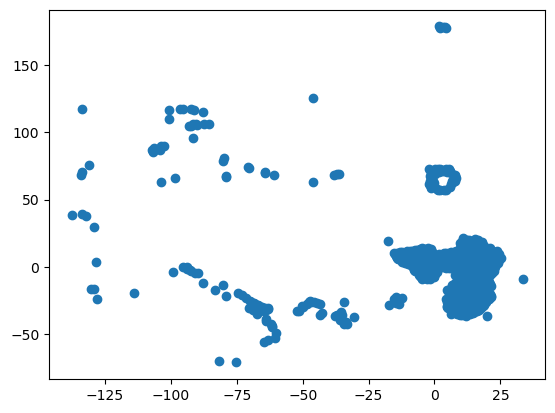

In [5]:
X_spatial = adata.obsm['X_spatial']
plt.figure()
plt.scatter(X_spatial[:, 0], X_spatial[:, 1])
plt.show()

In [6]:
cell_mask = (X_spatial[:, 0] > -25) & (X_spatial[:, 1] < 50)
adata = adata[cell_mask]

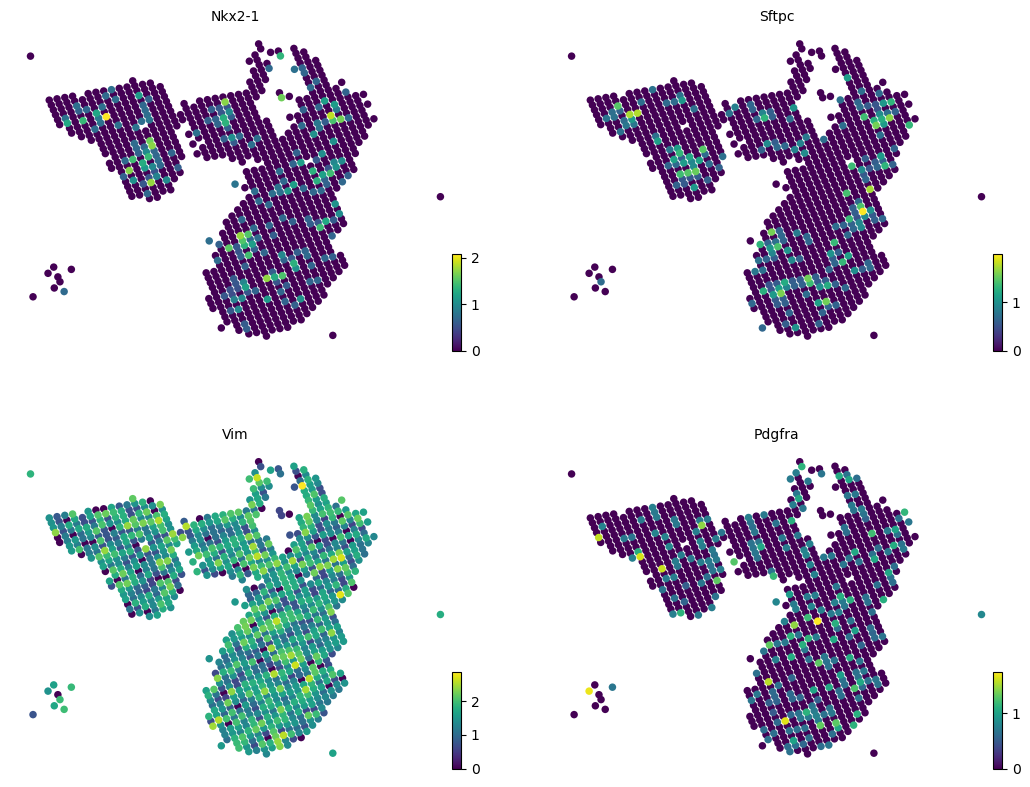

In [7]:
scv.pl.scatter(adata, basis='X_spatial', color=['Nkx2-1', 'Sftpc', 'Vim', 'Pdgfra'], ncols=2)

In [8]:
gidx = np.where(adata.var_names == "Nkx2-1")[0][0]
expr = adata.X[:, gidx].toarray().squeeze()
epi_mask = expr > 0
gidx = np.where(adata.var_names == "Sftpc")[0][0]
expr = adata.X[:, gidx].toarray().squeeze()
epi_mask = epi_mask | (expr > 0)
cell_labels = np.array(['Mesenchymal' for i in range(adata.n_obs)])
cell_labels[epi_mask] = 'Epithelial'

In [9]:
adata.obs['clusters'] = cell_labels

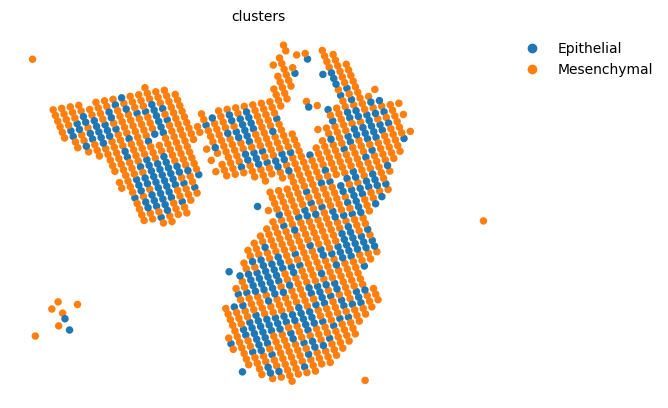

In [10]:
scv.pl.scatter(adata, basis='spatial')

In [11]:
tpv.preprocess(adata,
               n_gene=2000,
               min_shared_counts=20,
               min_shared_cells=1,
               min_counts_s=10,
               min_counts_u=10,
               spatial_key='X_spatial')

Filtered out 9803 genes that are detected 10 counts (spliced).
Filtered out 8845 genes that are detected 10 counts (unspliced).
Filtered out 2794 genes that are detected 20 counts (shared).
Normalized count data: spliced, unspliced.
Skip filtering by dispersion since number of variables are less than `n_top_genes`.
Computing the KNN graph based on X_pca
computing neighbors
    finished (0:00:02) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
Keep raw unspliced/spliced count data.
Perform spatial clustering.


In [13]:
adata.write_h5ad(f"{data_path_base}/adata_pp.h5ad")

# VeloVAE

In [3]:
adata = anndata.read_h5ad(f"{data_path_base}/adata_pp.h5ad")

In [4]:
figure_path = f'{figure_path_base}/vv'
model_path = f'{model_path_base}/vv'

torch.manual_seed(2022)
np.random.seed(2022)

vae = vv.VAE(adata, 
             tmax=20, 
             dim_z=10, 
             device='cuda:0',
             reverse_gene_mode=False)
config = {
    'batch_size':32,
}
genes = ['Foxp2', 'Gnas', 'Npm1']
vae.train(adata,
          config=config,
          plot=False,
          gene_plot=genes,
          figure_path=figure_path,
          embed='spatial')
vae.save_model(model_path, 'encoder', 'decoder')
vae.save_anndata(adata, 'vv', data_path_base, file_name="adata_out.h5ad")

Estimating ODE parameters...


  0%|          | 0/606 [00:00<?, ?it/s]

Detected 1 velocity genes.
Estimating the variance...


  0%|          | 0/606 [00:00<?, ?it/s]

Initialization using the steady-state and dynamical models.
Reinitialize the regular ODE parameters based on estimated global latent time.


  0%|          | 0/606 [00:00<?, ?it/s]

3 clusters detected based on gene co-expression.
(0.34, 0.18938674760245833), (0.66, 0.7250625029903051)
(0.67, 0.7461422907741898), (0.33, 0.22691605261491024)
(0.31, 0.21881723096955644), (0.69, 0.7832196503372496)
KS-test result: [0. 0. 0.]
Initial induction: 416, repression: 190/606
Learning Rate based on Data Sparsity: 0.0001
--------------------------- Train a VeloVAE ---------------------------
*********        Creating Training/Validation Datasets        *********
*********                      Finished.                      *********
*********                 Creating optimizers                 *********
*********                      Finished.                      *********
*********                    Start training                   *********
*********                      Stage  1                       *********
Total Number of Iterations Per Epoch: 23, test iteration: 44
*********       Stage 1: Early Stop Triggered at epoch 527.       *********
*********                 

  0%|          | 0/1030 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.215
Average Set Size: 36
*********     Round 1: Early Stop Triggered at epoch 552.    *********
Change in noise variance: 0.3272
*********             Velocity Refinement Round 2             *********
*********     Round 2: Early Stop Triggered at epoch 570.    *********
Change in noise variance: 0.0000
Change in x0: 0.9296
*********             Velocity Refinement Round 3             *********
*********     Round 3: Early Stop Triggered at epoch 578.    *********
Change in noise variance: 0.0000
Change in x0: 0.7357
*********             Velocity Refinement Round 4             *********
*********     Round 4: Early Stop Triggered at epoch 596.    *********
Change in noise variance: 0.0000
Change in x0: 0.6430
*********             Velocity Refinement Round 5             *********
*********     Round 5: Early Stop Triggered at epoch 604.    *********
Change in noise variance: 0.0000
Change in x0: 0.5945
*********             Velocity Refinement Round 6    

In [5]:
figure_path = f'{figure_path_base}/fullvb'
model_path = f'{model_path_base}/fullvb'

torch.manual_seed(2022)
np.random.seed(2022)

vae = vv.VAE(adata, 
             tmax=20, 
             dim_z=10, 
             device='cuda:0',
             full_vb=True,
             reverse_gene_mode=False)
config = {
    'batch_size':32,
}
genes = ['Foxp2', 'Gnas', 'Npm1']
vae.train(adata,
          config=config,
          plot=False,
          gene_plot=genes,
          figure_path=figure_path,
          embed='spatial')
vae.save_model(model_path, 'encoder', 'decoder')
vae.save_anndata(adata, 'fullvb', data_path_base, file_name="adata_out.h5ad")

Estimating ODE parameters...


  0%|          | 0/606 [00:00<?, ?it/s]

Detected 1 velocity genes.
Estimating the variance...


  0%|          | 0/606 [00:00<?, ?it/s]

Initialization using the steady-state and dynamical models.
Reinitialize the regular ODE parameters based on estimated global latent time.


  0%|          | 0/606 [00:00<?, ?it/s]

3 clusters detected based on gene co-expression.
(0.34, 0.18938674760245833), (0.66, 0.7250625029903051)
(0.67, 0.7461422907741898), (0.33, 0.22691605261491024)
(0.31, 0.21881723096955644), (0.69, 0.7832196503372496)
KS-test result: [0. 0. 0.]
Initial induction: 416, repression: 190/606
Learning Rate based on Data Sparsity: 0.0001
--------------------------- Train a VeloVAE ---------------------------
*********        Creating Training/Validation Datasets        *********
*********                      Finished.                      *********
*********                 Creating optimizers                 *********
*********                      Finished.                      *********
*********                    Start training                   *********
*********                      Stage  1                       *********
Total Number of Iterations Per Epoch: 23, test iteration: 44
*********       Stage 1: Early Stop Triggered at epoch 435.       *********
*********                 

  0%|          | 0/1030 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.173
Average Set Size: 30
*********     Round 1: Early Stop Triggered at epoch 466.    *********
Change in noise variance: 0.3261
*********             Velocity Refinement Round 2             *********
*********     Round 2: Early Stop Triggered at epoch 474.    *********
Change in noise variance: 0.0000
Change in x0: 0.8392
*********             Velocity Refinement Round 3             *********
*********     Round 3: Early Stop Triggered at epoch 482.    *********
Change in noise variance: 0.0000
Change in x0: 0.6601
*********             Velocity Refinement Round 4             *********
*********     Round 4: Early Stop Triggered at epoch 500.    *********
Change in noise variance: 0.0000
Change in x0: 0.5960
*********             Velocity Refinement Round 5             *********
*********     Round 5: Early Stop Triggered at epoch 508.    *********
Change in noise variance: 0.0000
Change in x0: 0.5875
*********             Velocity Refinement Round 6    

# TopoVelo

In [6]:
from sklearn.neighbors import NearestNeighbors
X_pos = adata.obsm['X_spatial']
nn = NearestNeighbors(n_neighbors=16)
nn.fit(X_pos)
adata.obsp['spatial_graph'] = nn.kneighbors_graph()

In [7]:
figure_path = f'{figure_path_base}/tpv'
model_path = f'{model_path_base}/tpv'

vae = tpv.VAE(adata, 
              tmax=20, 
              dim_z=10, 
              device='cuda:0',
              graph_decoder=True,
              attention=False,
              reverse_gene_mode=False)
config = {
    'batch_size':32
}
genes = ['Foxp2', 'Gnas', 'Npm1']
vae.train(adata,
          adata.obsp['spatial_graph'],
          "X_spatial",
          config=config,
          plot=False,
          gene_plot=genes,
          figure_path=figure_path,
          embed='spatial')
vae.save_model(model_path, 'encoder', 'decoder')
vae.save_anndata(adata, 'tpv', data_path_base, file_name="adata_out.h5ad")

Initialization using the steady-state and dynamical models.
Estimating ODE parameters...


  0%|          | 0/606 [00:00<?, ?it/s]

Detected 1 velocity genes.
Estimating the variance...


  0%|          | 0/606 [00:00<?, ?it/s]

3 clusters detected based on gene co-expression.
(0.34, 0.18936812376874682), (0.66, 0.7250651374051721)
(0.67, 0.7461351019645581), (0.33, 0.22690302626788428)
(0.31, 0.21877590226847557), (0.69, 0.783232821801893)
KS-test result: [0. 0. 0.]
Initial induction: 416, repression: 190/606
Initialization using the steady-state and dynamical models.
Reinitialize the regular ODE parameters based on estimated global latent time.


  0%|          | 0/606 [00:00<?, ?it/s]

Learning Rate based on Data Sparsity: 0.0001
--------------------------- Train a TopoVelo ---------------------------
*********               Creating a Graph Dataset              *********
*********                      Finished.                      *********
*********                 Creating optimizers                 *********
*********                      Finished.                      *********
*********                    Start training                   *********
*********                      Stage  1                       *********
*********       Stage 1: Early Stop Triggered at epoch 326.       *********
Summary: 
Train ELBO = 767.551
Test ELBO = 751.690
Total Time =   0 h :  1 m : 59 s

*********                      Stage  2                       *********
*********             Velocity Refinement Round 1              *********


  0%|          | 0/1030 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.062
Average Neighborhood Size: 42.7
Average Set Size: 9.0
Summary: 
Train ELBO = 1429.464
Test ELBO = 1390.389
Total Time =   0 h :  2 m : 11 s

*********       Round 1: Early Stop Triggered at epoch 367.       *********
Change in noise variance: 0.3218
*********             Velocity Refinement Round 2              *********
Summary: 
Train ELBO = 1355.808
Test ELBO = 1392.354
Total Time =   0 h :  2 m : 13 s

*********       Round 2: Early Stop Triggered at epoch 377.       *********
Change in noise variance: 0.0000
Change in x0: 0.6381
*********             Velocity Refinement Round 3              *********
Summary: 
Train ELBO = 1337.800
Test ELBO = 1393.123
Total Time =   0 h :  2 m : 15 s

*********       Round 3: Early Stop Triggered at epoch 385.       *********
Change in noise variance: 0.0000
Change in x0: 0.6172
*********             Velocity Refinement Round 4              *********
Summary: 
Train ELBO = 1340.602
Test ELBO = 1393.091
Total Time

## Graph Attention

In [8]:
figure_path = f'{figure_path_base}/gat'
model_path = f'{model_path_base}/gat'

vae = tpv.VAE(adata, 
              tmax=20, 
              dim_z=10, 
              device='cuda:0',
              graph_decoder=True,
              attention=True,
              reverse_gene_mode=False)
config = {
    'batch_size':32
}
genes = ['Foxp2', 'Gnas', 'Npm1']
vae.train(adata,
          adata.obsp['spatial_graph'],
          "X_spatial",
          config=config,
          plot=False,
          gene_plot=genes,
          figure_path=figure_path,
          embed='spatial')
vae.save_model(model_path, 'encoder_gat', 'decoder_gat')
vae.save_anndata(adata, 'gat', data_path_base, file_name="adata_out.h5ad")

Initialization using the steady-state and dynamical models.
Estimating ODE parameters...


  0%|          | 0/606 [00:00<?, ?it/s]

Detected 1 velocity genes.
Estimating the variance...


  0%|          | 0/606 [00:00<?, ?it/s]

3 clusters detected based on gene co-expression.
(0.34, 0.18936812376874682), (0.66, 0.7250651374051721)
(0.67, 0.7461351019645581), (0.33, 0.22690302626788428)
(0.31, 0.21877590226847557), (0.69, 0.783232821801893)
KS-test result: [0. 0. 0.]
Initial induction: 416, repression: 190/606
Initialization using the steady-state and dynamical models.
Reinitialize the regular ODE parameters based on estimated global latent time.


  0%|          | 0/606 [00:00<?, ?it/s]

Learning Rate based on Data Sparsity: 0.0001
--------------------------- Train a TopoVelo ---------------------------
*********               Creating a Graph Dataset              *********
*********                      Finished.                      *********
*********                 Creating optimizers                 *********
*********                      Finished.                      *********
*********                    Start training                   *********
*********                      Stage  1                       *********
*********       Stage 1: Early Stop Triggered at epoch 613.       *********
Summary: 
Train ELBO = 779.081
Test ELBO = 780.358
Total Time =   0 h :  9 m : 26 s

*********                      Stage  2                       *********
*********             Velocity Refinement Round 1              *********


  0%|          | 0/1030 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.049
Average Neighborhood Size: 42.7
Average Set Size: 9.4
Summary: 
Train ELBO = 1420.098
Test ELBO = 1420.023
Total Time =   0 h :  9 m : 42 s

*********       Round 1: Early Stop Triggered at epoch 633.       *********
Change in noise variance: 0.3261
*********             Velocity Refinement Round 2              *********
Summary: 
Train ELBO = 1430.362
Test ELBO = 1418.708
Total Time =   0 h :  9 m : 48 s

*********       Round 2: Early Stop Triggered at epoch 641.       *********
Change in noise variance: 0.0000
Change in x0: 0.6752
*********             Velocity Refinement Round 3              *********
Summary: 
Train ELBO = 1399.846
Test ELBO = 1415.048
Total Time =   0 h :  9 m : 54 s

*********       Round 3: Early Stop Triggered at epoch 649.       *********
Change in noise variance: 0.0000
Change in x0: 0.4799
*********             Velocity Refinement Round 4              *********
Summary: 
Train ELBO = 1393.707
Test ELBO = 1410.217
Total Time

# Informative Time Prior

In [9]:
tpv.model.model_util.get_spatial_tprior(adata, 20, q=0.95)

saving figure to file /scratch/welchjd_root/welchjd/shared_data/gyichen/figures/stereo-seq-lung-e13.5/tprior.png


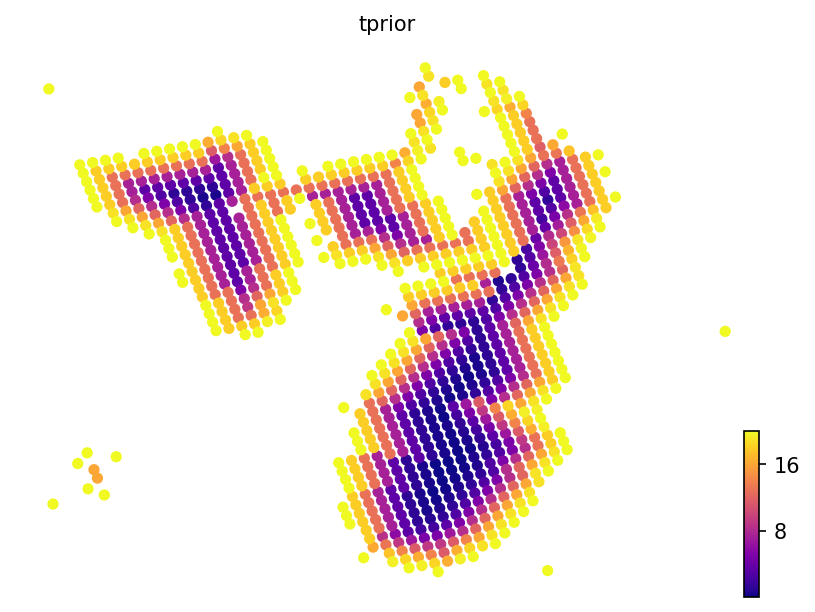

In [11]:
scv.pl.scatter(adata, basis='spatial', color='tprior', color_map='plasma', dpi=150,
               save=f"{figure_path_base}/tprior.png")

In [10]:
figure_path = f'{figure_path_base}/gat_tprior'
model_path = f'{model_path_base}/gat_tprior'

vae = tpv.VAE(adata, 
              tmax=20, 
              dim_z=10, 
              device='cuda:0',
              tprior='tprior',
              graph_decoder=True,
              attention=True,
              reverse_gene_mode=False)
config = {
    'batch_size':32,
    'kl_t': 1e-8
}
genes = ['Foxp2', 'Gnas', 'Npm1']
vae.train(adata,
          adata.obsp['spatial_graph'],
          "X_spatial",
          config=config,
          plot=False,
          gene_plot=genes,
          figure_path=figure_path,
          embed='spatial')
vae.save_model(model_path, 'encoder', 'decoder')
vae.save_anndata(adata, 'gat_tprior', data_path_base, file_name="adata_out.h5ad")

Initialization using the steady-state and dynamical models.
Estimating ODE parameters...


  0%|          | 0/606 [00:00<?, ?it/s]

Detected 1 velocity genes.
Estimating the variance...


  0%|          | 0/606 [00:00<?, ?it/s]

3 clusters detected based on gene co-expression.
(0.34, 0.18936812376874682), (0.66, 0.7250651374051721)
(0.67, 0.7461351019645581), (0.33, 0.22690302626788428)
(0.31, 0.21877590226847557), (0.69, 0.783232821801893)
KS-test result: [0. 0. 0.]
Initial induction: 416, repression: 190/606
Initialization using the steady-state and dynamical models.
Reinitialize the regular ODE parameters based on estimated global latent time.


  0%|          | 0/606 [00:00<?, ?it/s]

Using informative time prior.
Learning Rate based on Data Sparsity: 0.0001
--------------------------- Train a TopoVelo ---------------------------
*********               Creating a Graph Dataset              *********
*********                      Finished.                      *********
*********                 Creating optimizers                 *********
*********                      Finished.                      *********
*********                    Start training                   *********
*********                      Stage  1                       *********
*********                      Stage  2                       *********
*********             Velocity Refinement Round 1              *********


  0%|          | 0/1030 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.042
Average Neighborhood Size: 42.7
Average Set Size: 10.2
Summary: 
Train ELBO = -52333666053486804992.000
Test ELBO = -2592067594681365561344.000
Total Time =   0 h : 14 m : 33 s

*********       Round 1: Early Stop Triggered at epoch 1011.       *********
Change in noise variance: 0.3152
*********             Velocity Refinement Round 2              *********
Summary: 
Train ELBO = -90778389185837400064.000
Test ELBO = -2592067594681365561344.000
Total Time =   0 h : 14 m : 39 s

*********       Round 2: Early Stop Triggered at epoch 1019.       *********
Change in noise variance: 0.0011
Change in x0: 2.5979
*********             Velocity Refinement Round 3              *********
Summary: 
Train ELBO = -40171906366005313536.000
Test ELBO = -2592067594681365561344.000
Total Time =   0 h : 14 m : 45 s

*********       Round 3: Early Stop Triggered at epoch 1027.       *********
Change in noise variance: 0.0001
Change in x0: 1.3486
*********             Ve

In [11]:
scv.tl.recover_dynamics(adata)
scv.tl.velocity(adata, mode='dynamical')
scv.tl.velocity_graph(adata)
scv.tl.latent_time(adata)

recovering dynamics (using 1/32 cores)


  0%|          | 0/27 [00:00<?, ?gene/s]

    finished (0:00:04) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/32 cores)


  0%|          | 0/1030 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing terminal states
    identified 0 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:00) --> added 
    'latent_time', shared time (adata.obs)


In [12]:
adata.write_h5ad(f"{data_path_base}/adata_out.h5ad")

Computing velocity embedding using scVelo
computing velocity graph (using 1/32 cores)


  0%|          | 0/1030 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_spatial', embedded velocity vectors (adata.obsm)
computing velocity graph (using 1/32 cores)


  0%|          | 0/1030 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_spatial', embedded velocity vectors (adata.obsm)
Computing velocity embedding using scVelo
computing velocity graph (using 1/32 cores)


  0%|          | 0/1030 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'vv_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'vv_velocity_spatial', embedded velocity vectors (adata.obsm)
computing velocity graph (using 1/32 cores)


  0%|          | 0/1030 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'vv_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'vv_velocity_spatial', embedded velocity vectors (adata.obsm)
Computing velocity embedding using scVelo
computing velocity graph (using 1/32 cores)


  0%|          | 0/1030 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'fullvb_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'fullvb_velocity_spatial', embedded velocity vectors (adata.obsm)
computing velocity graph (using 1/32 cores)


  0%|          | 0/1030 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'fullvb_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'fullvb_velocity_spatial', embedded velocity vectors (adata.obsm)
Computing velocity embedding using scVelo
computing velocity graph (using 1/32 cores)


  0%|          | 0/1030 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'tpv_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'tpv_velocity_spatial', embedded velocity vectors (adata.obsm)
computing velocity graph (using 1/32 cores)


  0%|          | 0/1030 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'tpv_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'tpv_velocity_spatial', embedded velocity vectors (adata.obsm)
Computing velocity embedding using scVelo
computing velocity graph (using 1/32 cores)


  0%|          | 0/1030 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'gat_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'gat_velocity_spatial', embedded velocity vectors (adata.obsm)
computing velocity graph (using 1/32 cores)


  0%|          | 0/1030 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'gat_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'gat_velocity_spatial', embedded velocity vectors (adata.obsm)
---     Computing Peformance Metrics     ---
Dataset Size: 1030 cells, 606 genes
---   Plotting  Results   ---
computing velocity graph (using 1/32 cores)


  0%|          | 0/1030 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_spatial', embedded velocity vectors (adata.obsm)
saving figure to file /scratch/welchjd_root/welchjd/shared_data/gyichen/figures/stereo-seq-lung-e13.5/gut_fit_stream.png


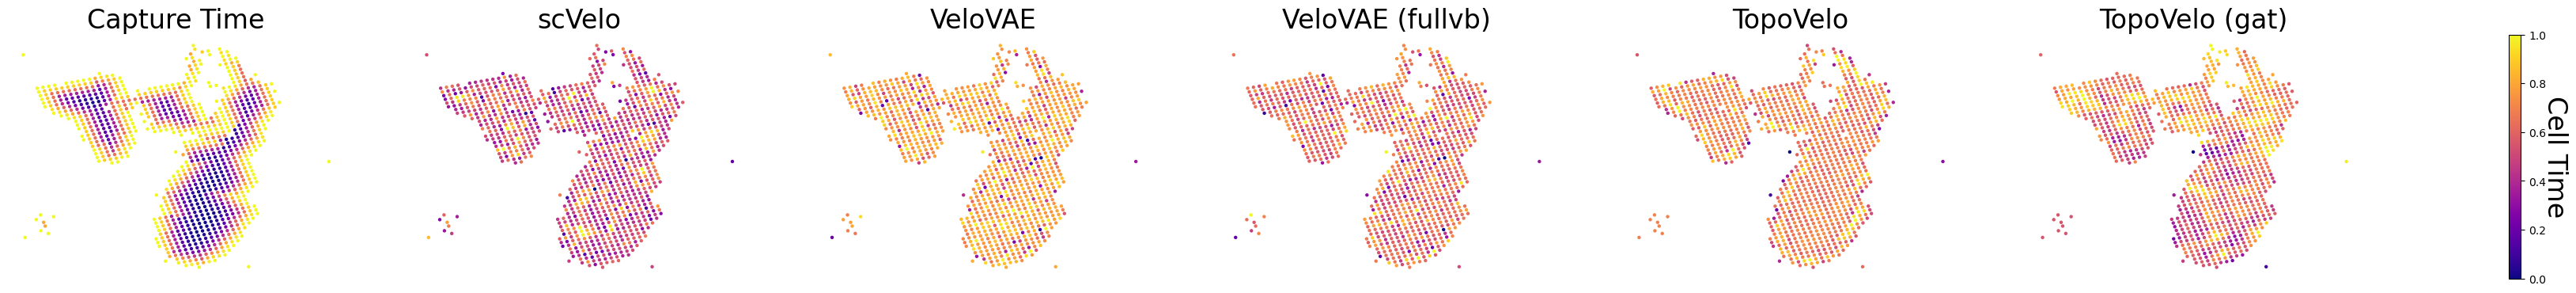

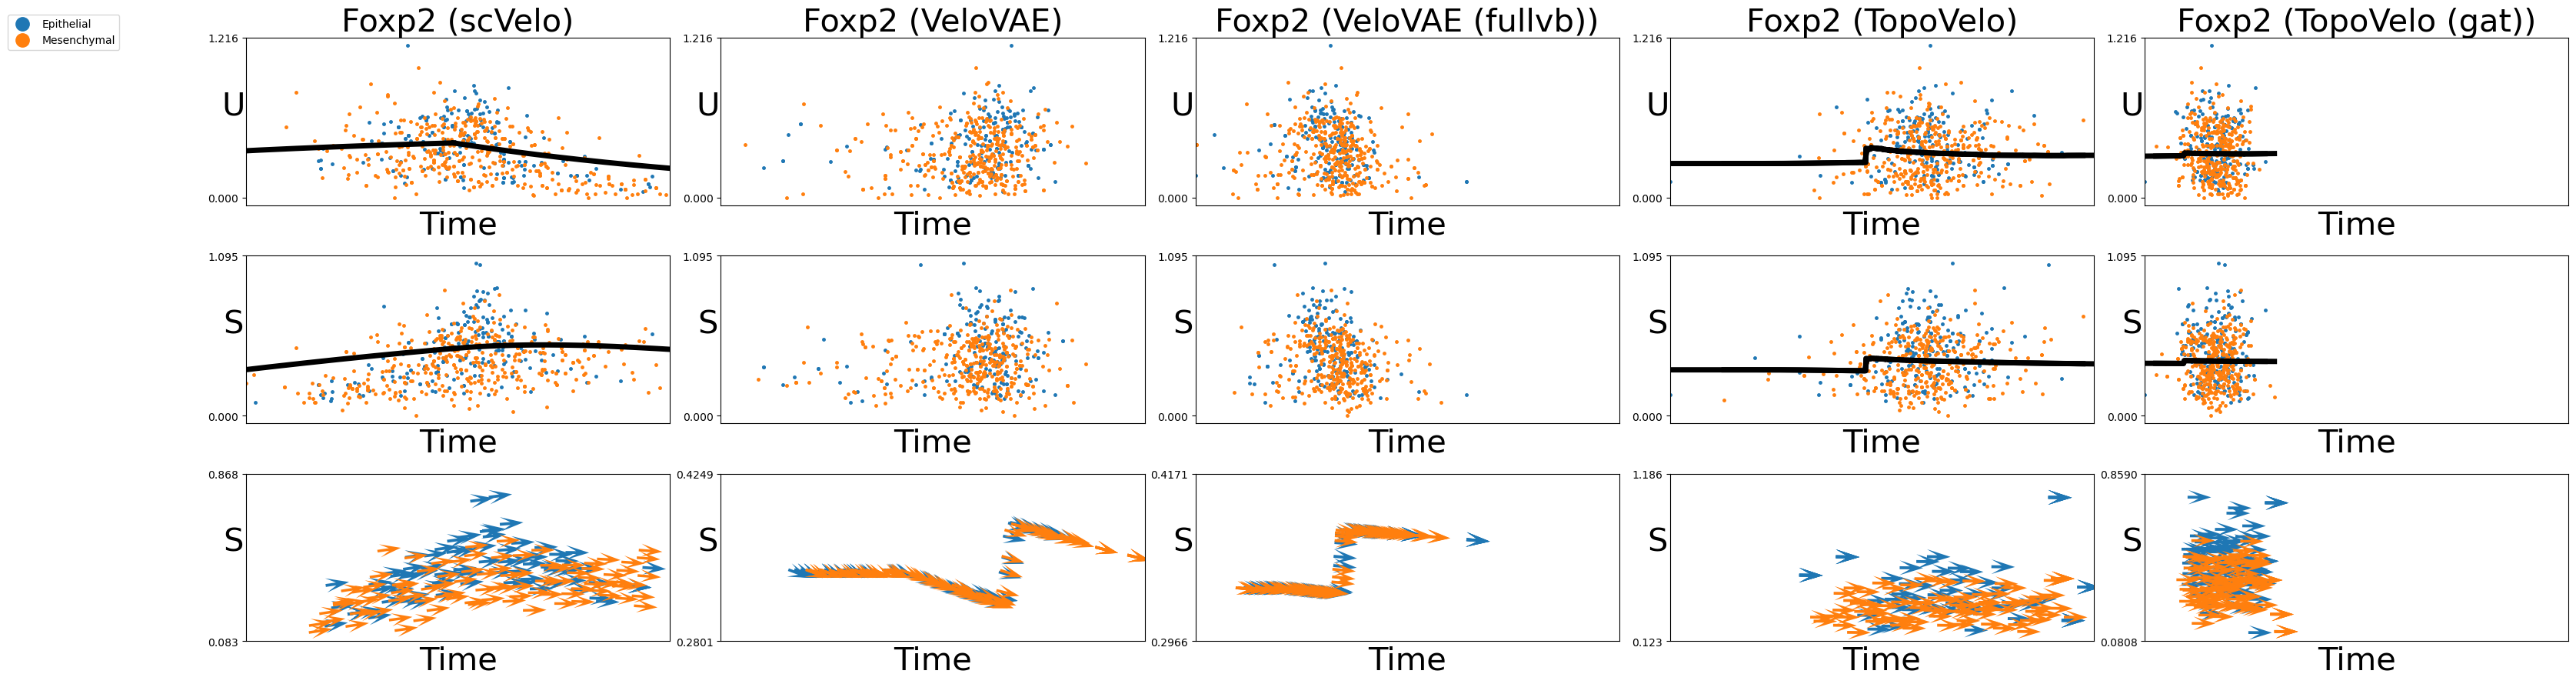

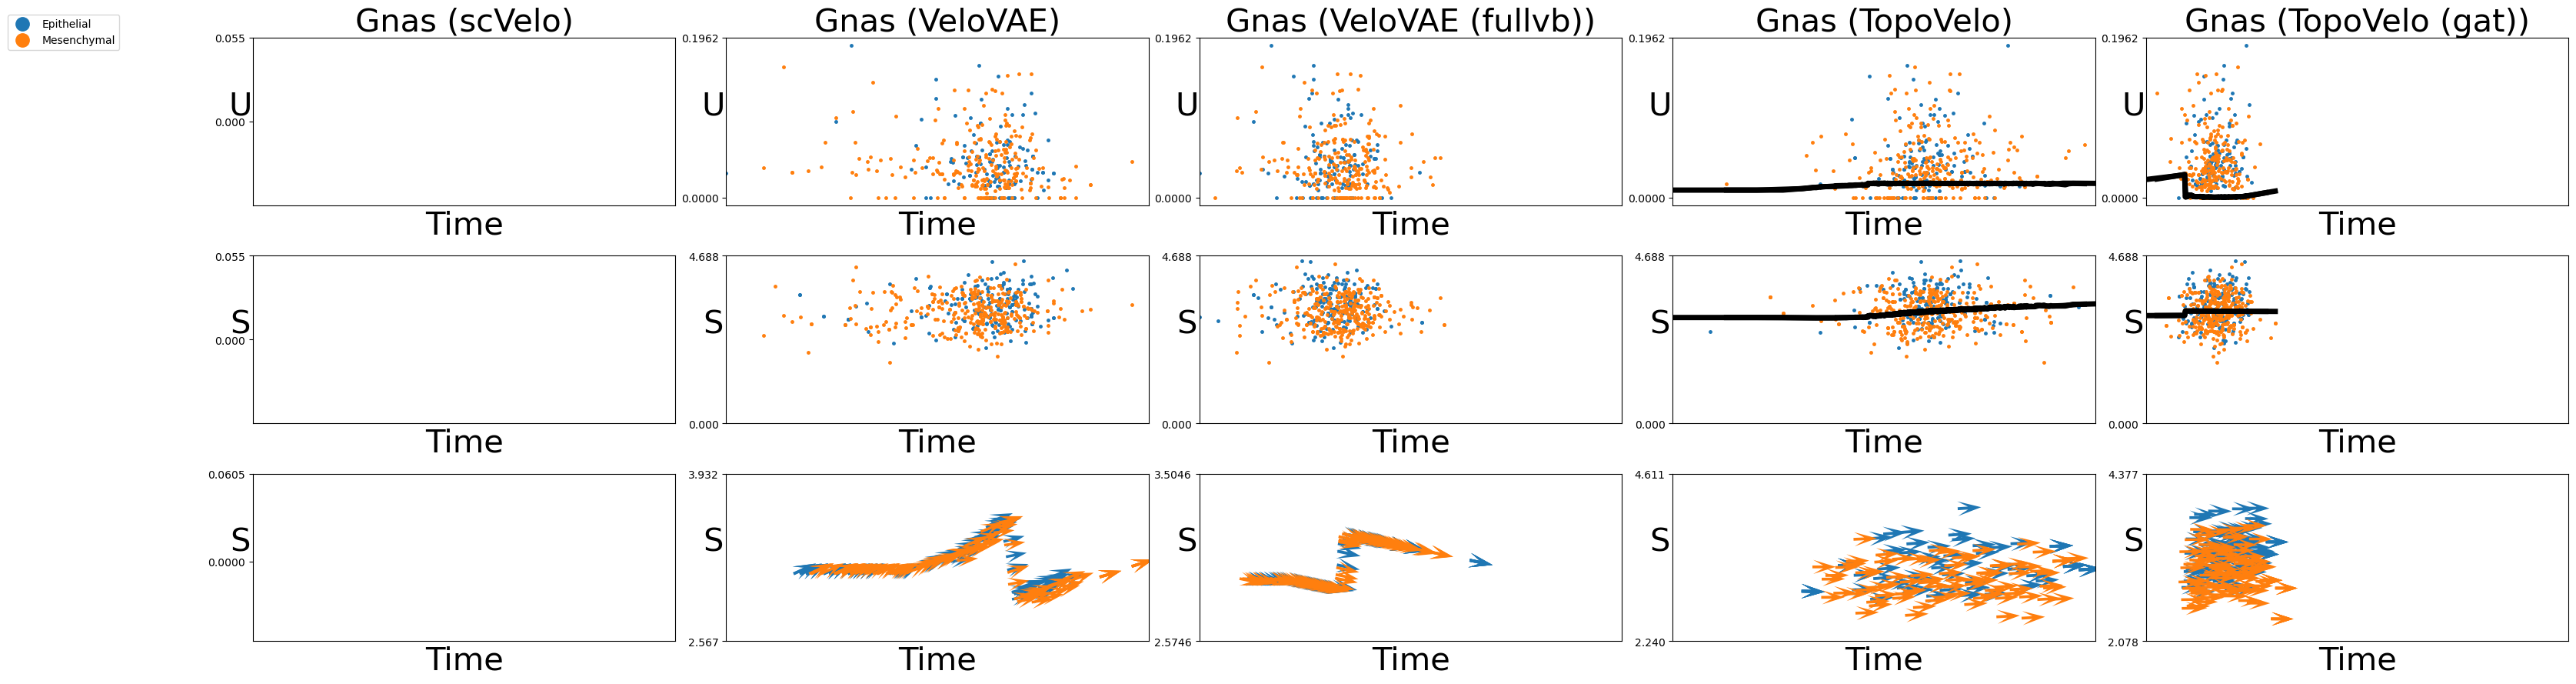

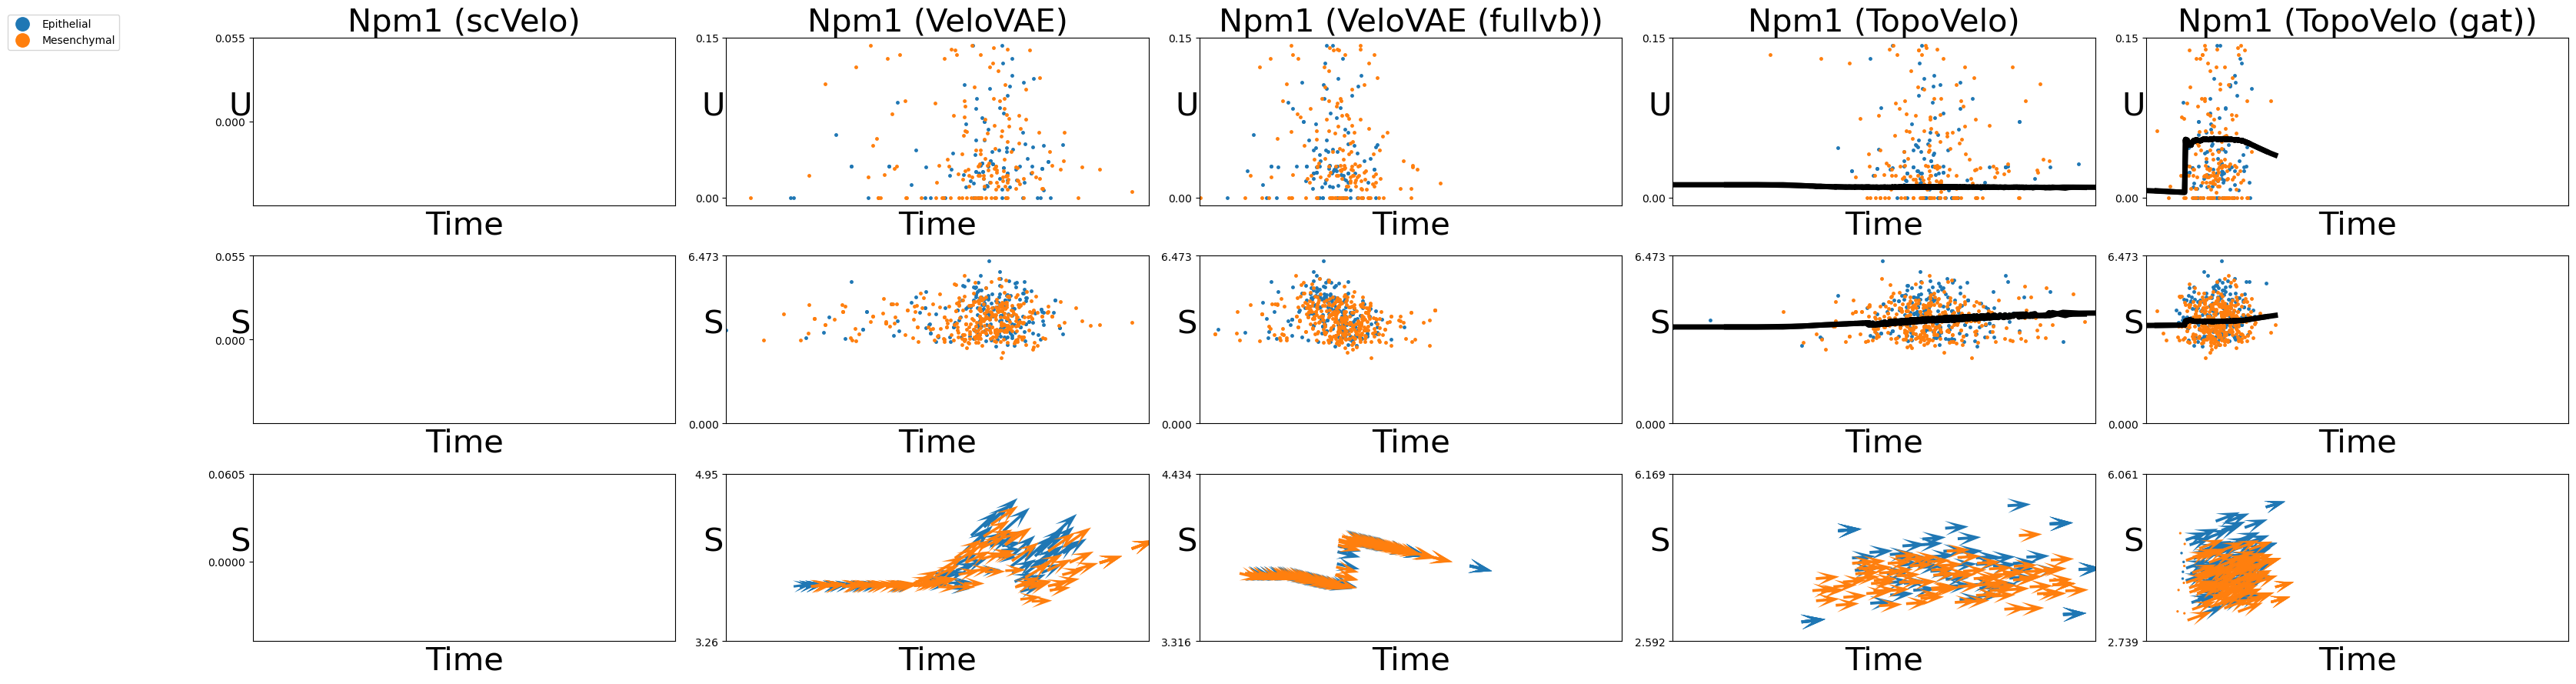

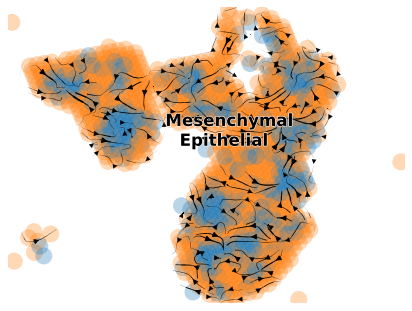

computing velocity graph (using 1/32 cores)


  0%|          | 0/1030 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'vv_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'vv_velocity_spatial', embedded velocity vectors (adata.obsm)
saving figure to file /scratch/welchjd_root/welchjd/shared_data/gyichen/figures/stereo-seq-lung-e13.5/gut_vv_stream.png


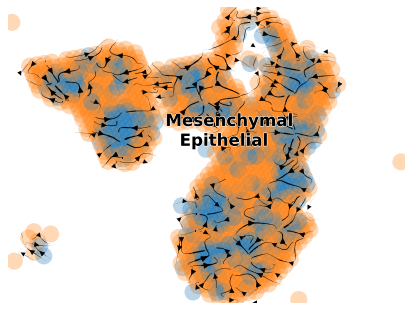

computing velocity graph (using 1/32 cores)


  0%|          | 0/1030 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'fullvb_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'fullvb_velocity_spatial', embedded velocity vectors (adata.obsm)
saving figure to file /scratch/welchjd_root/welchjd/shared_data/gyichen/figures/stereo-seq-lung-e13.5/gut_fullvb_stream.png


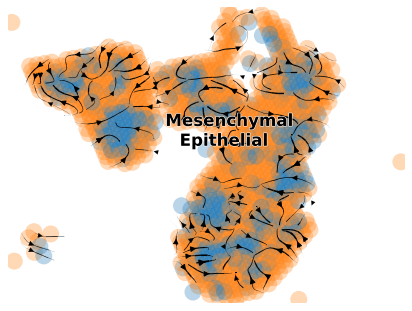

computing velocity graph (using 1/32 cores)


  0%|          | 0/1030 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'tpv_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'tpv_velocity_spatial', embedded velocity vectors (adata.obsm)
saving figure to file /scratch/welchjd_root/welchjd/shared_data/gyichen/figures/stereo-seq-lung-e13.5/gut_tpv_stream.png


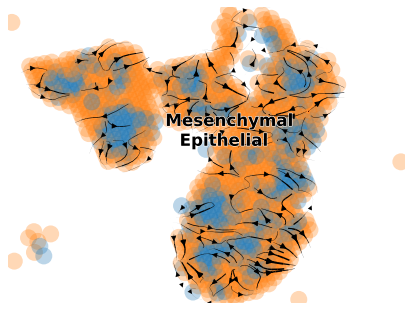

saving figure to file /scratch/welchjd_root/welchjd/shared_data/gyichen/figures/stereo-seq-lung-e13.5/gut_tpv_true_velocity.png


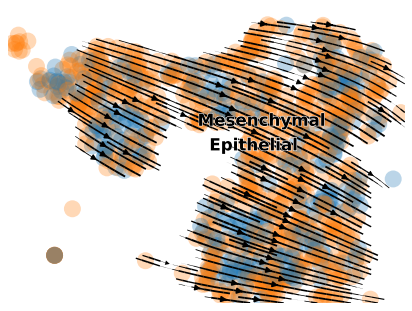

computing velocity graph (using 1/32 cores)


  0%|          | 0/1030 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'gat_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'gat_velocity_spatial', embedded velocity vectors (adata.obsm)
saving figure to file /scratch/welchjd_root/welchjd/shared_data/gyichen/figures/stereo-seq-lung-e13.5/gut_gat_stream.png


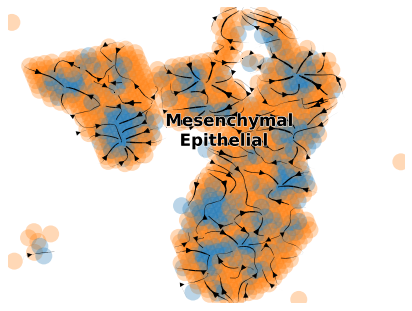

saving figure to file /scratch/welchjd_root/welchjd/shared_data/gyichen/figures/stereo-seq-lung-e13.5/gut_gat_true_velocity.png


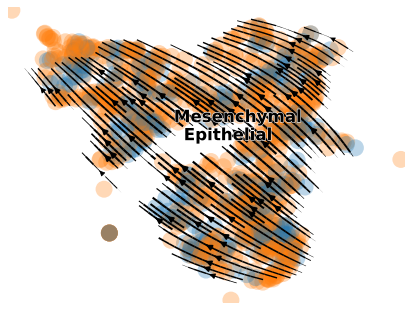

In [17]:
tpv.plotting.set_dpi(100)
res, res_type = tpv.post_analysis(adata,
                                  'gut',
                                  ['scVelo', 'VeloVAE', 'VeloVAE', 'TopoVelo', 'TopoVelo'],
                                  ['fit', 'vv', 'fullvb', 'tpv', 'gat'],
                                  spatial_graph_key='spatial_graph',
                                  spatial_key='X_spatial',
                                  compute_metrics=True,
                                  spatial_velocity_graph=True,
                                  genes=['Foxp2', 'Gnas', 'Npm1'],
                                  grid_size=(1, 1),
                                  embed='spatial',
                                  plot_type=['time', 'gene', 'stream'],
                                  figure_path=figure_path_base)

In [18]:
res

,scVelo,VeloVAE,VeloVAE (fullvb),TopoVelo,TopoVelo (gat)
MSE Train,0.061,0.044,0.034,0.032,0.034
MSE Test,NaN,0.038,0.034,0.035,0.036
MAE Train,0.197,0.163,0.155,0.151,0.162
MAE Test,NaN,0.159,0.156,0.153,0.163
LL Train,-47.656,63.893,63.446,65.042,53.674
LL Test,NaN,63.924,63.206,64.812,53.719
Training Time,NaN,NaN,NaN,NaN,NaN
corr,-0.083,-0.037,0.175,-0.040,0.047
"CBDir (Embed, Velocity Genes)",NaN,NaN,NaN,NaN,NaN
CBDir (Velocity Genes),NaN,NaN,NaN,NaN,NaN
